<a href="https://colab.research.google.com/github/Barryjuait/Barryjuait/blob/master/Dysk_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
import random
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dense, Input, Dropout, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Flatten, AveragePooling1D, LeakyReLU, BatchNormalization, UpSampling1D, Reshape
from keras.optimizers import SGD
from keras.models import Model, Sequential, load_model
from keras.callbacks import ModelCheckpoint
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d
from sklearn.model_selection import KFold, StratifiedKFold
from keras.utils import to_categorical

import scikitplot
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_cumulative_gain, plot_precision_recall, plot_lift_curve
from sklearn.metrics import confusion_matrix, roc_curve, auc


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [4]:
#set current working directory
path = '/content/drive/MyDrive/Colab Notebooks/'
os.chdir(path)

In [24]:
#Read the dataset into a pandas.DataFrame
Data = pd.read_csv(path + 'CollectedSpectra.csv')

In [105]:
#Scale the data and update the dataframe:
faxis = np.arange(0, 150.5, 0.5);
scaler = MinMaxScaler();
dummy = Data.iloc[:, range(len(faxis))];
result = scaler.fit_transform(dummy.T)
Data.iloc[:, range(len(faxis))] = result.T;

##Descriptive Analysis:

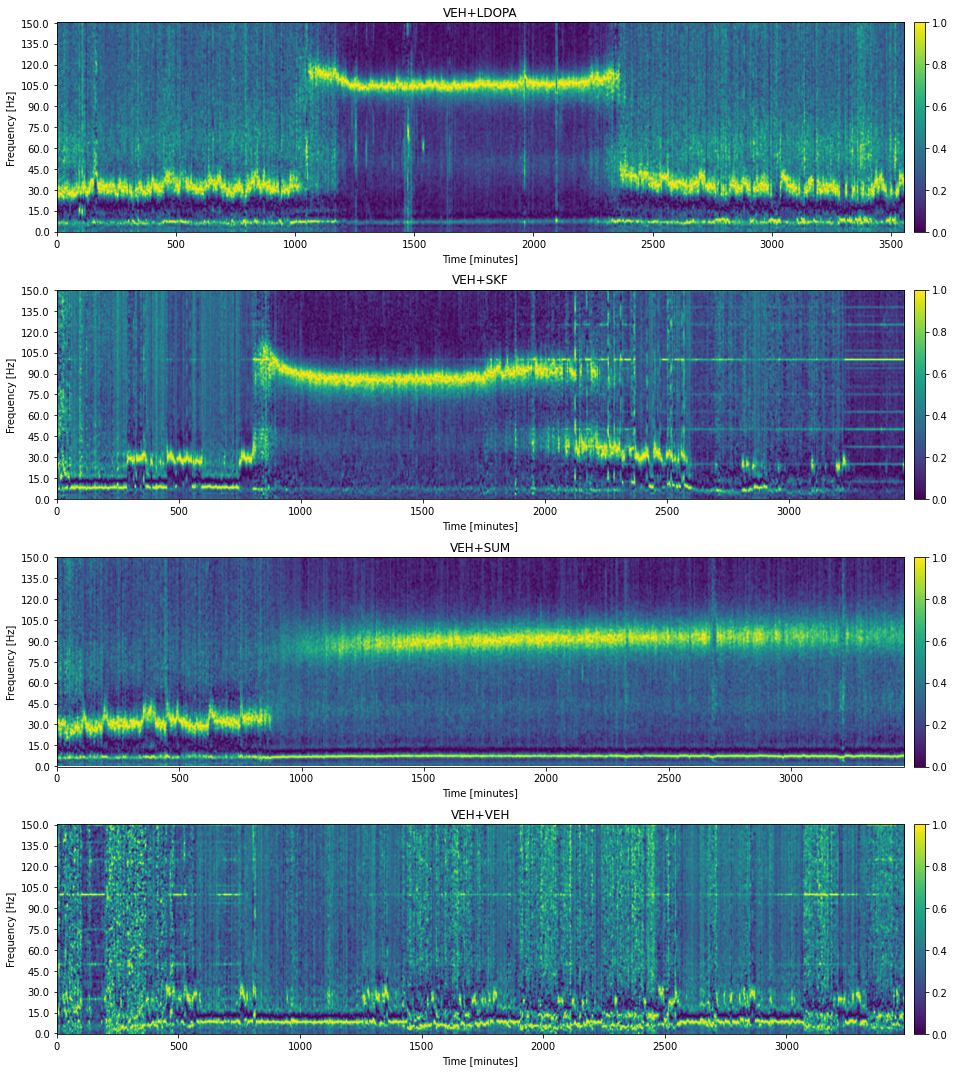

In [107]:
#Plot Spectrograms per Drug:
bDrugs = ['VEH+LDOPA', 'VEH+SKF', 'VEH+SUM', 'VEH+VEH'];

fig, ax = plt.subplots(len(bDrugs),1, figsize = (15,15))
for k in range(len(bDrugs)):
  sel = np.logical_and(Data.Hemi == 2, Data.Drug == k+1)
  bSessions = np.unique(Data.Session[sel]);
  idx = random.randint(0,len(bSessions));
  sel = np.logical_and(sel, Data.Session == bSessions[idx]);

  spg = np.array(Data.iloc[:, range(len(faxis))]);
  spg = spg[sel,:].T
  btaxis = np.array(Data.taxis[sel]);  
  
  pcm = ax[k].imshow(spg, aspect = 'auto');
  ax[k].invert_yaxis();
  fig.colorbar(pcm, ax=ax[k], pad = 0.01)
  ax[k].set_xlabel('Time [minutes]');
  fslice = range(0,len(faxis),30);
  ax[k].set_yticks(fslice);
  ax[k].set_yticklabels(faxis[fslice]);
  ax[k].set_ylabel('Frequency [Hz]');
  ax[k].set_title(f'{bDrugs[k]}');

fig.tight_layout()
plt.show();

In [79]:
def getStatesSpectra(Data):
  bDrugs = ['VEH+LDOPA', 'VEH+SKF', 'VEH+SUM', 'VEH+VEH'];
  faxis = np.arange(0, 150.5, 0.5);
  fig, ax = plt.subplots(1, len(bDrugs), figsize = (15,6));
  disc = np.logical_or(np.isnan(Data.State), np.in1d(Data.State, [-1, 4]));
  n_states = (np.unique(Data.State[~disc]));

  for j in range(len(n_states)):
    sel = np.logical_and(Data.Hemi == 2, ~disc);
    sel = np.logical_and(sel, Data.State == j);
    a = Data.iloc[list(sel), range(len(faxis))];
    #a = a[sel,:];
    a.columns = faxis;
    a['Drug'] = Data.Drug[sel];
    a = a.reset_index();

    melted = a.melt(id_vars= ['index', 'Drug'], var_name='faxis', value_name='power_spectra').sort_index('index')
    melted.rename(columns={'index':'bindex'}, inplace=True);
    melted.faxis = melted.faxis.astype('category');
    melted.sort_values('bindex', inplace = True);

    sns.lineplot(data = melted, x = 'faxis', y = 'power_spectra', hue = 'Drug', ax = ax[j])
    ax[j].set_xlabel('Frequency [Hz]')
    ax[j].set_ylabel('Scaled Power');
    ax[j].set_title(f'State {j}', fontsize = 14);
    ax[j].grid();

    x = np.unique(a.Drug.astype(int)) - 1; #getting the right drug indexes
    ax[j].legend([bDrugs[ix] for ix in x]); #slicing the list of drugs
  fig.tight_layout()
  plt.show();


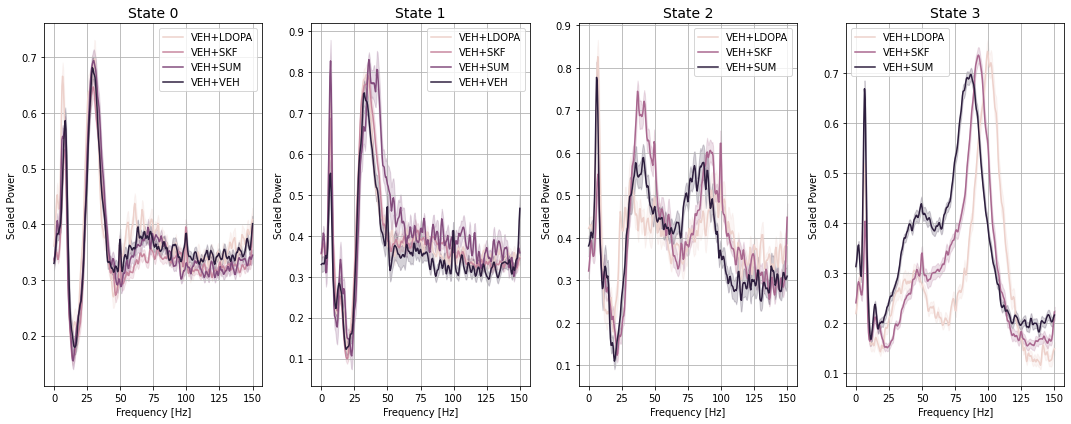

In [81]:
#Plot Spectra per State per Drug:
getStatesSpectra(Data)

In [89]:
#make a copy:
df = Data.copy();

#remove nans:
df.dropna(subset=['State'], axis=0, inplace=True);

#leave only right hemisphere:
df.drop(df[np.in1d(df['State'], [-1, 4])].index, inplace = True);
df.drop(df[df['Hemi'] == 1].index, inplace = True);

#update:
df.State = df.State;
df.reset_index(drop=True, inplace=True);

In [90]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
x0,4440.0,0.315697,0.123277,0.000000,0.235362,0.303586,0.384031,0.852010
x0_5,4440.0,0.323437,0.117512,0.009945,0.246421,0.310608,0.388173,0.863817
x1,4440.0,0.334297,0.112360,0.042240,0.261165,0.321025,0.397202,0.900501
x1_5,4440.0,0.348580,0.113806,0.063018,0.273372,0.331196,0.411975,1.000000
x2,4440.0,0.356172,0.122470,0.079277,0.277014,0.336212,0.415864,1.000000
...,...,...,...,...,...,...,...,...
Session,4440.0,181.963288,51.083244,81.000000,140.000000,179.000000,230.000000,250.000000
Drug,4440.0,2.422297,0.969598,1.000000,2.000000,2.000000,3.000000,4.000000
taxis,4440.0,51.694107,66.111615,-50.000000,-4.966667,50.133333,100.733333,180.983333
Hemi,4440.0,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [9]:
def plotStateSpectra(X, y):
  n_states = len(np.unique(y))
  fig, ax = plt.subplots(1,n_states,figsize = (15,6), sharey = True);
  dummy = pd.DataFrame(X);
  faxis = np.arange(0, 150.5, 0.5);
  for ix in range(n_states):
    a = dummy.loc[y == ix,'0':'300'];
    a.columns = faxis;
    a = a.reset_index();

    melted = a.melt(id_vars='index', var_name='faxis', value_name='power_spectra').sort_index('index')
    melted.rename(columns={'index':'bindex'}, inplace=True);
    melted.faxis = melted.faxis.astype('category');
    melted.sort_values('bindex', inplace = True);

    sns.lineplot(data = melted, x = 'faxis', y = 'power_spectra', ax = ax[ix])
    ax[ix].set_xlabel('Frequency [Hz]')
    ax[ix].set_ylabel('Scaled Power');
    ax[ix].set_title(f'State {ix}', fontsize = 14);
    ax[ix].grid();
  plt.show();

In [84]:
#Set X and y for the analysis:
faxis = np.arange(0, 150.5, 0.5);
X = np.array(df.iloc[:, range(len(faxis))]);
y = np.array(df.State.astype('category'));

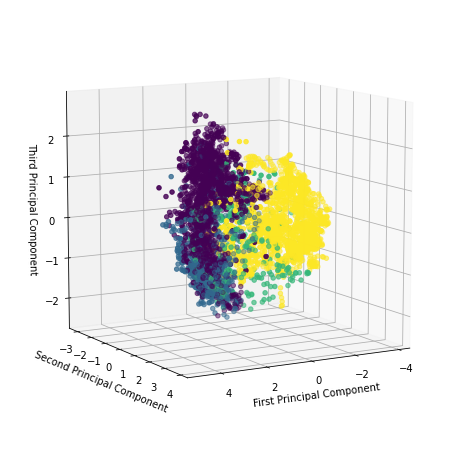

In [13]:
#Check how does the data looks like:
import numpy as np

# Initialize PCA
pca = PCA()

# Fit the PCA model to the data
pca.fit(X)

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components needed to explain at least 80% of the variance
n_components = np.argmax(cumulative_explained_variance >= 0.8) + 1

# Update the PCA model with the number of components needed to explain at least 80% of the variance
pca = PCA(n_components=n_components)
pca.fit(X)

# Perform dimensionality reduction on the data
X_reduced = pca.transform(X)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d');

ax.scatter(X_reduced[:,0], X_reduced[:,1], X_reduced[:,2], c = y);
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")
ax.set_zlabel("Third Principal Component")
ax.view_init(10, 60);

plt.show()


## Predictive Model: 1D-CNN

https://towardsdatascience.com/types-of-convolution-kernels-simplified-f040cb307c37

###Model Design:

In [57]:
def getModel(num_features, num_classes):
  # Define the model
  input_layer = Input(shape=(num_features, 1), dtype = 'float32')  # shape of input data
  conv_layer1 = Conv1D(filters=100, kernel_size= 3, activation='relu', padding = 'same')(input_layer)
  conv_layer2 = Conv1D(filters=100, kernel_size= 3, activation='relu', padding = 'same')(conv_layer1)
  pool_layer1 = MaxPooling1D(pool_size=3)(conv_layer2)
  conv_layer3 = Conv1D(filters=100, kernel_size= 3, activation='relu', padding = 'same')(pool_layer1)
  conv_layer4 = Conv1D(filters=100, kernel_size= 3, activation='relu', padding = 'same')(conv_layer3)
  pool_layer2 = AveragePooling1D(pool_size=3)(conv_layer4)
  dropout_layer1 = Dropout(0.5)(pool_layer2)
  flatten_layer = Flatten()(dropout_layer1)
  dense1 = Dense(32, activation='relu')(flatten_layer)
  dense2 = Dense(16, activation='relu')(dense1)
  dense3 = Dense(8, activation='relu')(dense2)
  dropout_layer2 = Dropout(0.2)(dense3)
  output_layer = Dense(units=num_classes, activation='softmax')(dropout_layer2)  # output layer with 10 units and softmax activation

  # Compile the model
  model = Model(inputs=input_layer, outputs=output_layer)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  #model.summary()
  return model


'''
The data_augmentation function takes in a 1D array arr, 
and the parameters sigma and alpha for jittering and magnitude warping respectively. 
The function returns the augmented array. The jitter and magnitude_warp functions 
implement the data augmentation techniques.

'''

def jitter(arr, sigma):
    return arr + np.random.normal(scale=sigma, size=arr.shape)

def magnitude_warp(arr, alpha):
    return arr * (1 + alpha * np.random.normal(size=arr.shape))

#def data_augmentation(arr, y, sigma, alpha):
 #   arr = jitter(arr, sigma)
  #  arr = magnitude_warp(arr, alpha)
   # return arr

def data_augmentation(data, y, sigma, alpha):
    augmented_data = [];
    new_y = [];
    for k in range(data.shape[0]):
        arr = data[k,:];
        new_y.append(y[k]);
        new_y.append(y[k]);        
        new_y.append(y[k]);        
        augmented_data.append(arr);
        augmented_data.append(jitter(arr, sigma));
        augmented_data.append(magnitude_warp(arr, alpha));
    return np.array(augmented_data), new_y

In [62]:
# Train the model using 5-fold cross validation
xval = 2; #cross-validation rounds
nepochs = 5; #number of epochs
num_features = np.shape(X)[1];
bStates = np.unique(y);
num_classes = len(bStates);
kfold = StratifiedKFold(n_splits=xval, shuffle=True);

#save models on every iteration:
model_path = path + 'models';
save_weights_at = os.path.join(model_path, 'dysk.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1);

scores = [];
lossx = [];
lossxval = [];
accx = [];
accxval = [];
  
#for train_index, test_index in kfold.split(X, y):
for ix in range(num_classes):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

  # Apply data augmentation to the training data
  #X_train = np.array([data_augmentation(arr, y, sigma=0.1, alpha=0.1) for arr in X_train])
  X_train, y_train = data_augmentation(X_train, y_train, sigma=0.1, alpha=0.1);

  # Convert the labels to categorical format
  y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)

  model = getModel(num_features, num_classes);
  history = model.fit(X_train, y_train, batch_size=32, epochs=nepochs, verbose=1, 
                      shuffle=True, callbacks=[save_best], validation_data=(X_test, y_test));

  # Plot the training and validation loss
  lossx.append(history.history['loss']);
  lossxval.append(history.history['val_loss']);
  accx.append(history.history['accuracy']);
  accxval.append(history.history['val_accuracy']);

  _, acc = model.evaluate(X_test, y_test, verbose=0)

  scores.append(acc)

print("Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(scores)*100, np.std(scores)*100))


Epoch 1/5
279/279 [==============================] - 10s 21ms/step - loss: 0.6985 - accuracy: 0.7375 - val_loss: 0.4547 - val_accuracy: 0.8302
Epoch 2/5
279/279 [==============================] - 3s 12ms/step - loss: 0.5127 - accuracy: 0.8065 - val_loss: 0.3789 - val_accuracy: 0.8574
Epoch 3/5
279/279 [==============================] - 5s 16ms/step - loss: 0.4270 - accuracy: 0.8376 - val_loss: 0.3595 - val_accuracy: 0.8670
Epoch 4/5
279/279 [==============================] - 9s 34ms/step - loss: 0.3848 - accuracy: 0.8553 - val_loss: 0.2883 - val_accuracy: 0.8909
Epoch 5/5
279/279 [==============================] - 8s 27ms/step - loss: 0.3468 - accuracy: 0.8722 - val_loss: 0.2525 - val_accuracy: 0.9045
Epoch 1/5
279/279 [==============================] - 11s 27ms/step - loss: 0.7028 - accuracy: 0.7329 - val_loss: 0.4232 - val_accuracy: 0.8295
Epoch 2/5
279/279 [==============================] - 10s 36ms/step - loss: 0.5023 - accuracy: 0.7947 - val_loss: 0.3863 - val_accuracy: 0.8404
Epo

###Performance of the Model:

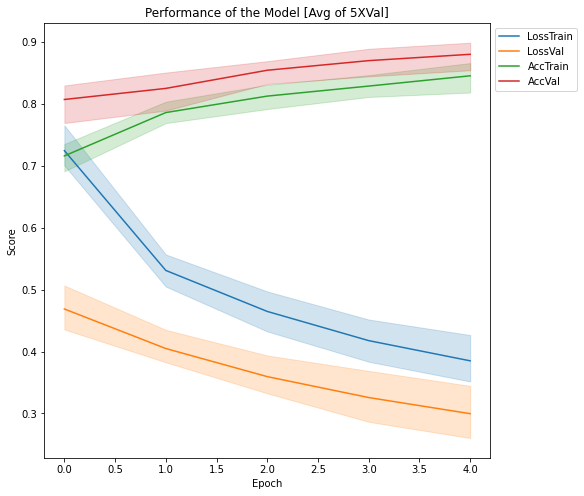

In [63]:
# Create an empty dataframe
edf = pd.DataFrame(columns=['LossTrain', 'LossVal', 'AccTrain', 'AccVal', 'Epoch', 'XValRound'])

# Loop through the sublists and add their values to the dataframe
for ix in range(len(lossx)):
    sublists_df = pd.DataFrame({'LossTrain': lossx[ix], 'LossVal': lossxval[ix], 
                               'AccTrain': accx[ix], 'AccVal': accxval[ix], 
                               'Epoch': list(range(len(lossx[ix]))), 
                                'XValRound': [ix] * len(lossx[ix])});
    edf = edf.append(sublists_df, ignore_index=True)

# Reset the index of the dataframe
edf = edf.reset_index(drop=True);

# Plot the training and validation loss:
fig, ax = plt.subplots(1,1, figsize = (8,8));
sns.lineplot(data = edf, x = 'Epoch', y = 'LossTrain', label = 'LossTrain', ax = ax);
sns.lineplot(data = edf, x = 'Epoch', y = 'LossVal', label = 'LossVal', ax = ax);
sns.lineplot(data = edf, x = 'Epoch', y = 'AccTrain', label = 'AccTrain', ax = ax);
sns.lineplot(data = edf, x = 'Epoch', y = 'AccVal', label = 'AccVal', ax = ax);
ax.set_ylabel('Score')
ax.set_xlabel('Epoch')
ax.set_title('Performance of the Model [Avg of 5XVal]')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1));
plt.show()

In [64]:
# Get the index of the epoch with the lowest validation loss
min_loss_index = np.argmin(edf.LossVal);
best_val_loss = edf.LossVal[min_loss_index];
best_epoch = edf.Epoch[min_loss_index] + 1;
print(f'Best Validation Loss: {best_val_loss:.4f} at epoch {best_epoch}');

Best Validation Loss: 0.2525 at epoch 5


In [65]:
best_model = load_model(os.path.join(model_path, f'dysk.{best_epoch:02d}-{best_val_loss:.4f}.hdf5'));

# Get the predicted probabilities
pred_probs = best_model.predict(X_test);

# The shape of pred_probs will be (number of test samples, number of classes)
print(pred_probs.shape)

# Each row represents the predicted probabilities for a single test sample
print(pred_probs[0])

46/46 [==============================] - 1s 20ms/step
(1466, 4)
[9.20561254e-01 7.88252354e-02 5.98735292e-04 1.47819865e-05]


In [66]:
originalStates = np.argmax(y_test, axis = 1);
predStates = np.argmax(pred_probs, axis = 1)
print(f'Original States: {np.unique(originalStates)}');
print(f'Predicted States: {np.unique(predStates)}');

Original States: [0 1 2 3]
Predicted States: [0 1 2 3]


In [67]:
mae = mean_absolute_error(originalStates, predStates)
print(f'MAE for the validation set: {mae:.4f}')

MAE for the validation set: 0.1132


In [68]:
r2 = r2_score(predStates, originalStates)
print('R-squared for the validation set:', round(r2,4))

R-squared for the validation set: 0.913


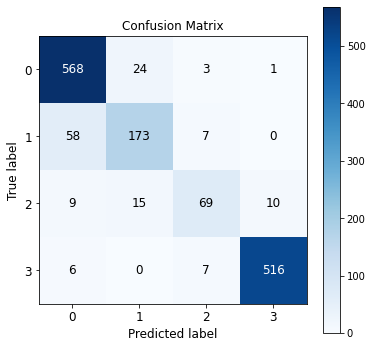

In [69]:
# Plot the confusion matrix and the ROC curve in the same figure

# Plot the confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_confusion_matrix(originalStates, predStates, title = 'Confusion Matrix',text_fontsize = 'large', title_fontsize = 'large', ax = ax)
ax.set_title("Confusion Matrix")
plt.show()

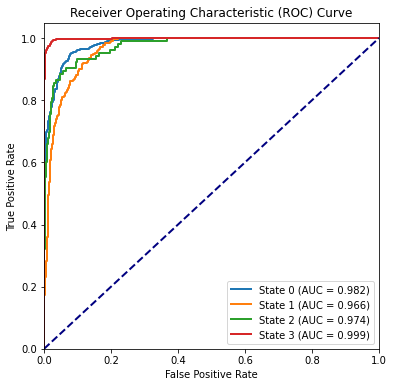

In [70]:
# Plot the ROC curve
bStates = np.unique(originalStates);
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for k in range(len(bStates)):
  fpr, tpr, thresholds = roc_curve(originalStates == bStates[k], pred_probs[:,k]);
  roc_auc = auc(fpr, tpr)

  ax.plot(fpr, tpr, lw=2, label= f'State {bStates[k]} (AUC = {roc_auc:0.3f})')

ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc="lower right")

plt.show()

### Apply the model to the rest of the data:

In [74]:
#Get a copy from the original:
dfx = Data.copy();
dfx.dropna(subset=['Session'], axis=0, inplace=True);
dfx.reset_index(drop=True, inplace=True);
Acc = dfx.Acc;
Hemi = dfx.Hemi;
AIMS = dfx.AIMS;
Drug = dfx.Drug.astype(int);
Session = dfx.Session;
taxis = dfx.taxis;
State = dfx.State;
State[State == 4] = None; #This state will not be counted
State[State == -1] = None; #Noise state will be set as 4

In [75]:
faxis = np.arange(0, 150.5, 0.5);
Xx = np.array(dfx.iloc[:, range(len(faxis))]);

# Get the predicted probabilities
originalStates = State.astype('category');

In [95]:
bSessions = np.unique(Session);
idx = random.randint(0,len(bSessions));

sel = np.logical_and(Session == bSessions[idx], Hemi == 2);
dummy = Xx[sel,:];

pred_probs = best_model.predict(dummy);
predStates = np.argmax(pred_probs, axis = 1);

109/109 [==============================] - 0s 3ms/step


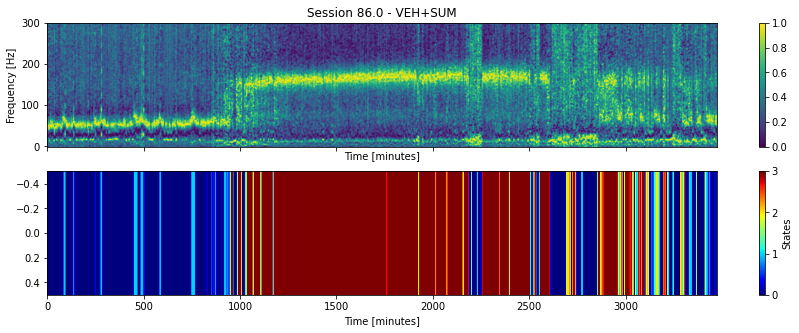

In [96]:
spg = Xx[sel,:].T;
btaxis = np.array(taxis[sel]);
bOrStates = np.array(originalStates[sel]);
bPredStates = np.array(predStates);
bDrugs = ['VEH+LDOPA', 'VEH+SKF', 'VEH+SUM', 'VEH+VEH'];

fig, ax = plt.subplots(2,1, figsize = (15,5), sharex = True)
pcm = ax[0].imshow(spg, aspect = 'auto');
ax[0].invert_yaxis();
fig.colorbar(pcm, ax=ax[0])
#ax[0].set_xticks(range(spg.shape[1]));
#ax[0].set_xticklabels(btaxis);
#ax[0].set_yticks(range(spg.shape[0]));
#ax[0].set_yticklabels(faxis);
ax[0].set_xlabel('Time [minutes]');
ax[0].set_ylabel('Frequency [Hz]');
ax[0].set_title(f'Session {bSessions[ix]} - {bDrugs[np.unique(Drug[sel])[0]-1]}');

plotStates1 = bOrStates.reshape((1, bOrStates.shape[0]));
plotStates2 = bPredStates.reshape((1, bPredStates.shape[0]));
pcm = ax[1].imshow(plotStates2, aspect = 'auto', cmap = 'jet');
cbar = fig.colorbar(pcm, ax=ax[1], ticks = [ 0, 1, 2, 3, 4], 
                    spacing='proportional', format='%1i', label = 'States')
ax[1].set_xlabel('Time [minutes]');
plt.show();

Too short events might be a problem, so "short states" of less than 1 minutes will be smoothed: 

In [81]:
def remove_short_events(data, n_states, threshold):
    unique_scores = np.unique(data)
    # Ensure that there are 5 unique scores
    assert len(unique_scores) == n_states, "Data must have n_states unique scores"

    for score in unique_scores:
        score_indices = np.where(data == score)[0]
        # Find the indices of the events
        event_start_indices = np.where(np.diff(score_indices) > 1)[0] + 1
        event_end_indices = np.concatenate([[score_indices[0]], np.where(np.diff(score_indices) > 1)[0]])

        # Find the duration of each event
        event_durations = event_end_indices - event_start_indices + 1

        # Find the events that are shorter than the threshold
        short_event_indices = np.where(event_durations < threshold)[0]

        # Replace the short events with NaN
        for i in short_event_indices:
            start_index = event_start_indices[i]
            end_index = event_end_indices[i]
            data[score_indices[start_index:end_index + 1]] = np.nan

    return data

def interpolate_imputation(data):
    not_nan = np.where(~np.isnan(data))[0]
    nan = np.where(np.isnan(data))[0]

    data[nan] = np.interp(nan, not_nan, data[not_nan])
    return data

Let's use the previous example to see how it changes:

ValueError: ignored

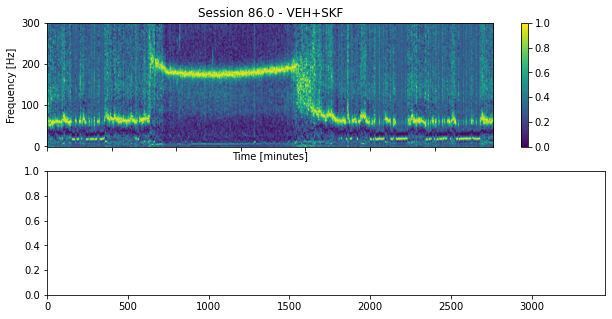

In [82]:
bDrugs = ['VEH+LDOPA', 'VEH+SKF', 'VEH+SUM', 'VEH+VEH'];

fig, ax = plt.subplots(2,1, figsize = (10,5), sharex = True)
pcm = ax[0].imshow(spg, aspect = 'auto');
ax[0].invert_yaxis();
fig.colorbar(pcm, ax=ax[0])
ax[0].set_xlabel('Time [minutes]');
ax[0].set_ylabel('Frequency [Hz]');
ax[0].set_title(f'Session {bSessions[ix]} - {bDrugs[np.unique(Drug[sel])[0]-1]}');

dummy = bPredStates.reshape((1, bPredStates.shape[0])).astype(float);
dummy[dummy == 4] = np.nan;
dummy = interpolate_imputation(dummy);

threshold = len(btaxis[np.logical_and(btaxis >= 0, btaxis < 1)]);
cleanx = remove_short_events(dummy, len(bStates), round(threshold/5));
plotStates2 = interpolate_imputation(cleanx);

pcm = ax[1].imshow(plotStates2, aspect = 'auto', cmap = 'jet');
cbar = fig.colorbar(pcm, ax=ax[1], spacing='proportional', format='%1i')
ax[1].set_xlabel('Time [minutes]');
plt.show();

In [ ]:
round(threshold/5)

3

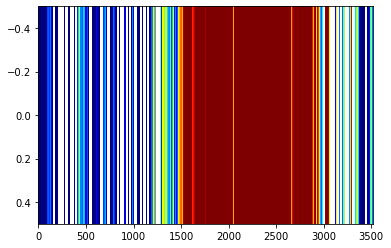

In [ ]:
plt.imshow(dummy, aspect = 'auto', cmap = 'jet');